**Table of contents**<a id='toc0_'></a>    
- 1. [Preface](#toc1_)    
- 2. [Algorithms](#toc2_)    
  - 2.1. [Relationship](#toc2_1_)    
  - 2.2. [Diversity](#toc2_2_)    
    - 2.2.1. [Richness Index](#toc2_2_1_)    
    - 2.2.2. [Shannon Diversity Index](#toc2_2_2_)    
    - 2.2.3. [Simpson Diversity Index](#toc2_2_3_)    
    - 2.2.4. [Pielou's Evenness Index](#toc2_2_4_)    
    - 2.2.5. [Bray-Curtis 相似性指数](#toc2_2_5_)    
    - 2.2.6. [Jaccard 相似性指数](#toc2_2_6_)    
- 3. [Diversity Analysis](#toc3_)    
  - 3.1. [Read datas](#toc3_1_)    
    - 3.1.1. [OTU table](#toc3_1_1_)    
    - 3.1.2. [Metainformation table](#toc3_1_2_)    
- 4. [Network analysis](#toc4_)    
- 5. [Convert](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Preface](#toc0_)

I plan rewritte all agrithms with PyTorch, and could run on GPU device.

<div style="display:flex;justify-content:center">

```mermaid
graph TD
    python[Python tool] --"PyTorch, Numpy"--> algorithm[Algorithm];
    math[Math background] --"Diversity"--> algorithm[Algorithm];
```

</div>

# 2. <a id='toc2_'></a>[Algorithms](#toc0_)

## 2.1. <a id='toc2_1_'></a>[Correlation](#toc0_)

In [6]:
#@save
import torch 


def pearson(X:torch.Tensor, Y:torch.Tensor) -> torch.Tensor:
   '''
   Pearson
   Args:
        X: tensor(N, )
        Y: tensor(N, )
    return:
        pearson: tensor
   '''
   X_centered = X - X.mean()
   Y_centered = Y - Y.mean()

   covariance = (X_centered * Y_centered).sum()
   x_std = torch.sqrt((X_centered ** 2).sum())
   y_std = torch.sqrt(torch.pow(Y_centered, 2).sum())
   
   r = covariance / (x_std * y_std)
   return r 



def spearman(X:torch.Tensor, Y:torch.Tensor) -> torch.Tensor:
   '''
   spearman
   Args:
       X, Y: tensor(N, )
   Return: 
       spearman: tensor
   '''
   d = X - Y
   n = len(X)
   r = 6 * (torch.pow(d, 2).sum()) / ((n-1)*(n**2))
   return r


def sparcc():
   pass 

pearson: 1.00/1.00
spearman: 0.07/0.07


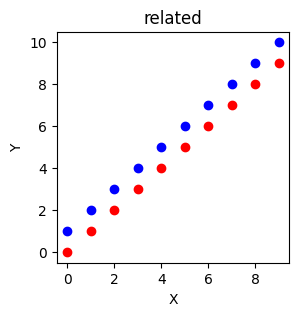

In [7]:
import matplotlib.pyplot as plt 
from scipy.stats import pearsonr, spearmanr


# calc pearson
X = torch.arange(10, dtype= torch.float)
Y = torch.arange(10, dtype= torch.float) + 1


plt.figure(figsize= (3, 3))
plt.scatter(torch.arange(10), X, color= 'red')
plt.scatter(torch.arange(10), Y, color= "blue")
plt.title(f"related")
plt.xlabel("X")
plt.ylabel("Y")
print(f"pearson: {pearson(X, Y):.2f}/{pearsonr(X, Y).correlation:.2f}")
print(f"spearman: {spearman(X, Y):.2f}/{spearman(X, Y):.2f}")

## 2.2. <a id='toc2_2_'></a>[Diversity](#toc0_)

### 2.2.1. <a id='toc2_2_1_'></a>[Richness Index](#toc0_)

form: S = 物种总数

解释: 丰富度指数是最简单的多样性指标，仅计算群落中存在的不同物种数量，而不考虑物种的相对丰度。

In [8]:
#@save 
import torch


def richness_index(species_counts):
    """
    计算丰富度指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: int, 物种总数。
    """
    return torch.count_nonzero(species_counts).item()

In [9]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])  # 第一个群落的物种个体数

# 计算丰富度指数
richness = richness_index(species_counts)
print("Richness Index:", richness)

Richness Index: 4


form: $S_{\text{Chao1}} = S_{\text{obs}} + \frac{n_1 (n_1 - 1)}{2 (n_2 + 1)}$


其中：
- Sobs: 观测到的物种数量
- n1: 只出现一次的物种数量（单例）
- n2 : 出现两次的物种数量（双例）

解释: Chao1 指数利用稀有物种的频率来推测未观测到的物种数量，适合稀疏采样的数据。

In [10]:
#@save 
def chao1_richness(species_counts):
    """
    计算Chao1丰富度估计指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: float, Chao1估计值。
    """
    n1 = torch.sum(species_counts == 1)  # 单例物种数量
    n2 = torch.sum(species_counts == 2)  # 双例物种数量
    s_obs = richness_index(species_counts)  # 观测到的物种数量
    if n2 == 0:
        n2 = 1  # 避免除以零
    chao1 = s_obs + (n1 * (n1 - 1)) / (2 * (n2 + 1))
    return chao1.item()

In [11]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])

# 计算Chao1丰富度估计指数
chao1 = chao1_richness(species_counts)
print("Chao1 Richness Estimate:", chao1)

Chao1 Richness Estimate: 4.0


### 2.2.2. <a id='toc2_2_2_'></a>[Shannon Diversity Index](#toc0_)

Shannon Diversity Index, H 

香农多样性指数结合了物种丰富度和均匀度： $H=-\sum_{i=1}^Sp_i\ln(p_i)$

- $p_i$ :第 i 个物种的相对丰度

解释: 香农指数衡量的是“不确定性”或信息熵。当所有物种的丰度相等时，不确定性最大；当少数物种占主导地位时，不确定性较小。

In [12]:
#@save 
def shannon_diversity_index(species_counts):
    """
    计算香农多样性指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: float, 香农指数值。
    """
    total = torch.sum(species_counts)
    p = species_counts / total  # 计算相对丰度
    p = p[p > 0]  # 去掉零丰度的物种
    h = -torch.sum(p * torch.log(p))  # 香农公式
    return h.item()

In [13]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])

# 计算香农多样性指数
shannon = shannon_diversity_index(species_counts)
print("Shannon Diversity Index:", shannon)

Shannon Diversity Index: 1.1355507373809814


### 2.2.3. <a id='toc2_2_3_'></a>[Simpson Diversity Index](#toc0_)

form: $D = \sum_{i=1}^{S} p_i^2$

or: $D' = \frac{1}{D}$

- $p_i$ :第 i 个物种的相对丰度

解释: 辛普森指数衡量从群落中随机抽取两个个体属于同一物种的概率。值越小，表示多样性越高。

In [14]:
#@save 
def simpson_diversity_index(species_counts):
    """
    计算辛普森多样性指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: float, 辛普森指数值。
    """
    total = torch.sum(species_counts)
    p = species_counts / total  # 计算相对丰度
    d = torch.sum(p**2)  # 辛普森公式
    return d.item()

In [15]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])

# 计算辛普森多样性指数
simpson = simpson_diversity_index(species_counts)
print("Simpson Diversity Index:", simpson)

Simpson Diversity Index: 0.3739612400531769


### 2.2.4. <a id='toc2_2_4_'></a>[Pielou's Evenness Index](#toc0_)

form: $J = \frac{H}{H_{\text{max}}}$

- H: 实际香农指数
- Hmax =ln(S): 当所有物种丰度相等时的最大香农指数
- S: 物种总数

解释: 均匀度指数衡量物种分布的均衡性。值接近 1 表示物种分布非常均匀，值接近 0 表示分布不均。

In [16]:
#@save 
def pielou_evenness_index(species_counts):
    """
    计算皮卢均匀度指数。
    :param species_counts: Tensor, 每个物种的个体数。
    :return: float, 均匀度指数值。
    """
    h = shannon_diversity_index(species_counts)  # 计算香农指数
    s = richness_index(species_counts)  # 计算物种丰富度
    h_max = torch.log(torch.tensor(s, dtype=torch.float32))  # 理论最大香农指数
    j = h / h_max  # 均匀度公式
    return j.item()

In [17]:
# 示例数据
species_counts = torch.tensor([10, 5, 0, 3, 1])

# 计算皮卢均匀度指数
pielou = pielou_evenness_index(species_counts)
print("Pielou's Evenness Index:", pielou)

Pielou's Evenness Index: 0.8191267251968384


### 2.2.5. <a id='toc2_2_5_'></a>[Bray-Curtis 相似性指数](#toc0_)

form: $BC = 1 - \frac{\sum_{i=1}^{S} |x_i - y_i|}{\sum_{i=1}^{S} (x_i + y_i)}$

其中：
- xi ,yi : 分别是两个群落中第 i 个物种的丰度

解释: Bray-Curtis 指数衡量两个群落物种丰度的差异。值越接近 0 表示差异越大，越接近 1 表示相似性越高。

In [18]:
#@save 
def bray_curtis_similarity(species_counts_a, species_counts_b):
    """
    计算Bray-Curtis相似性指数。
    :param species_counts_a: Tensor, 第一个群落的物种个体数。
    :param species_counts_b: Tensor, 第二个群落的物种个体数。
    :return: float, Bray-Curtis相似性值。
    """
    diff = torch.abs(species_counts_a - species_counts_b)
    total = species_counts_a + species_counts_b
    bc = 1 - torch.sum(diff) / torch.sum(total)
    return bc.item()

In [19]:
# 示例数据
species_counts_a = torch.tensor([10, 5, 0, 3, 1])
species_counts_b = torch.tensor([8, 6, 0, 2, 0])

# 计算Bray-Curtis相似性指数
bray_curtis = bray_curtis_similarity(species_counts_a, species_counts_b)
print("Bray-Curtis Similarity:", bray_curtis)

Bray-Curtis Similarity: 0.8571428656578064


### 2.2.6. <a id='toc2_2_6_'></a>[Jaccard 相似性指数](#toc0_)

form: $J = \frac{|A \cap B|}{|A \cup B|}$

其中：
- A,B: 分别是两个群落的物种集合
- ∣A∩B∣: 两个群落共有的物种数量
- ∣A∪B∣: 两个群落的所有物种数量

解释: Jaccard 指数衡量两个群落共享物种的比例。值越接近 1 表示相似性越高。

In [20]:
#@save 
def jaccard_similarity(species_counts_a, species_counts_b):
    """
    计算Jaccard相似性指数。
    :param species_counts_a: Tensor, 第一个群落的物种个体数。
    :param species_counts_b: Tensor, 第二个群落的物种个体数。
    :return: float, Jaccard相似性值。
    """
    a = set(torch.nonzero(species_counts_a, as_tuple=True)[0].tolist())
    b = set(torch.nonzero(species_counts_b, as_tuple=True)[0].tolist())
    # print(a, b)
    intersection = len(a.intersection(b))
    union = len(a.union(b))
    jaccard = intersection / union
    return jaccard

In [21]:
# 示例数据
species_counts_a = torch.tensor([10, 5, 0, 3, 1])
species_counts_b = torch.tensor([8, 6, 0, 2, 0])

# 计算Jaccard相似性指数
jaccard = jaccard_similarity(species_counts_a, species_counts_b)
print("Jaccard Similarity:", jaccard)

Jaccard Similarity: 0.75


# 3. <a id='toc3_'></a>[Diversity Analysis](#toc0_)

## 3.1. <a id='toc3_1_'></a>[Read datas](#toc0_)

### 3.1.1. <a id='toc3_1_1_'></a>[OTU table](#toc0_)

In [1]:
import pandas as pd 
# import modin.pandas as pd
# import cudf 


abundance_table = pd.read_table("results/feature_table/zotutab_raw.txt", index_col= "#OTU ID").T

In [2]:
abundance_table.index.name = "SampleID"

In [3]:
print(abundance_table.shape)
abundance_table.head()

(3660, 165993)


#OTU ID,Zotu34128,Zotu3,Zotu155,Zotu70143,Zotu178,Zotu1224,Zotu164013,Zotu10824,Zotu170,Zotu35795,...,Zotu86187,Zotu49885,Zotu149363,Zotu119196,Zotu153049,Zotu120303,Zotu151601,Zotu165776,Zotu136577,Zotu74829
SampleID,,,,,,,,,,,,,,,,,,,,,
F146a,4,166,15,2,86,3,3,3,44,7,...,0,0,0,0,0,0,0,0,0,0
F146b,1,121,11,1,57,2,0,0,22,0,...,0,0,0,0,0,0,0,0,0,0
F146c,1,191,14,0,95,2,3,2,58,0,...,0,0,0,0,0,0,0,0,0,0
F146d,0,106,10,0,60,1,2,0,17,1,...,0,0,0,0,0,0,0,0,0,0
F146e,1,233,33,3,83,1,0,3,63,5,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# wide table to long table
long_abundance_table = pd.melt(
    frame= abundance_table.reset_index(), 
    id_vars= ['SampleID'], 
    var_name= "OTU", 
    value_name= "Counts"
)

In [5]:
print(long_abundance_table.shape)
long_abundance_table.head()

(607534380, 3)


,SampleID,OTU,Counts
0,F146a,Zotu34128,4
1,F146b,Zotu34128,1
2,F146c,Zotu34128,1
3,F146d,Zotu34128,0
4,F146e,Zotu34128,1


### 3.1.2. <a id='toc3_1_2_'></a>[Metainformation table](#toc0_)

In [6]:
metainfo = pd.read_excel("datas/metadata.xlsx", sheet_name="clean")

In [7]:
print(metainfo.shape)
metainfo.head()

(3916, 50)


,SampleID,Group,Code,PartName,Part,AreaName,Area,Loacation,City,Longitude,...,Disease,早疫病,晚疫病,疮痂病,黑痣病,粉痂病,青枯病,黑胫病,枯萎病,病毒病
0,G1a,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,早疫病,3,0,0,0,0,0,0,0,0
1,G1b,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,早疫病,3,0,0,0,0,0,0,0,0
2,G1c,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,早疫病,3,0,0,0,0,0,0,0,0
3,G1d,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,早疫病,3,0,0,0,0,0,0,0,0
4,G1e,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,早疫病,3,0,0,0,0,0,0,0,0


In [8]:
# Unnamed: 22
# Unnamed: 28
# Remarks
metainfo = metainfo[metainfo.columns[0:29]]

In [9]:
metainfo.head()

,SampleID,Group,Code,PartName,Part,AreaName,Area,Loacation,City,Longitude,...,Mode,Scale,EarlyBlight,LateBlight,CommonScab,BlackScurf,PowderyScab,BactericalWilt,BlackLeg,Wilt
0,G1a,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,Single,Large,3,0,0,0,0,0,0,0
1,G1b,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,Single,Large,3,0,0,0,0,0,0,0
2,G1c,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,Single,Large,3,0,0,0,0,0,0,0
3,G1d,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,Single,Large,3,0,0,0,0,0,0,0
4,G1e,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,Single,Large,3,0,0,0,0,0,0,0


In [10]:
# counter = 1
# for i in metainfo.index:
#     if i not in abundance_table.columns:
#         print(counter, i)
#         counter += 1

# 将metainfo和abundance_table的所有样品对应上，即据abundance table提取metainfo信息成为新的metainfo
metainfo = metainfo[metainfo['SampleID'].isin(abundance_table.index)]

In [11]:
print(metainfo.shape)
metainfo.head()

(3660, 29)


,SampleID,Group,Code,PartName,Part,AreaName,Area,Loacation,City,Longitude,...,Mode,Scale,EarlyBlight,LateBlight,CommonScab,BlackScurf,PowderyScab,BactericalWilt,BlackLeg,Wilt
0,G1a,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,Single,Large,3,0,0,0,0,0,0,0
1,G1b,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,Single,Large,3,0,0,0,0,0,0,0
2,G1c,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,Single,Large,3,0,0,0,0,0,0,0
3,G1d,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,Single,Large,3,0,0,0,0,0,0,0
4,G1e,G1,1,Rhizosphere,1,Southwest Winter-Spring,2,Yunnan,Lincang,99.805835,...,Single,Large,3,0,0,0,0,0,0,0


In [12]:
len(metainfo["Group"].unique())

736

In [13]:
# # 将元信息与丰度表关联
# abundance_table_with_group = abundance_table.T.reset_index()
# # abundance_table_with_group = abundance_table.T
# abundance_table_with_group = abundance_table_with_group.rename(columns={"index": "Sample_ID"})
# abundance_table_with_group = abundance_table_with_group.merge(metainfo, on="Sample_ID")

# # print("\nAbundance Table with Group Information:")
# abundance_table_with_group = abundance_table_with_group.set_index("Sample_ID")
# abundance_table_with_group

In [14]:
abundance_table_with_group = pd.merge(long_abundance_table, metainfo, on= "SampleID")

In [15]:
print(abundance_table_with_group.shape)
abundance_table_with_group.head()

(607534380, 31)


,SampleID,OTU,Counts,Group,Code,PartName,Part,AreaName,Area,Loacation,...,Mode,Scale,EarlyBlight,LateBlight,CommonScab,BlackScurf,PowderyScab,BactericalWilt,BlackLeg,Wilt
0,F146a,Zotu34128,4,F146,146,Bulk,2,Northern Single-cropping,1,Heilongjiang,...,Single,Large,3,0,5,0,0,0,0,0
1,F146b,Zotu34128,1,F146,146,Bulk,2,Northern Single-cropping,1,Heilongjiang,...,Single,Large,3,0,5,0,0,0,0,0
2,F146c,Zotu34128,1,F146,146,Bulk,2,Northern Single-cropping,1,Heilongjiang,...,Single,Large,3,0,5,0,0,0,0,0
3,F146d,Zotu34128,0,F146,146,Bulk,2,Northern Single-cropping,1,Heilongjiang,...,Single,Large,3,0,5,0,0,0,0,0
4,F146e,Zotu34128,1,F146,146,Bulk,2,Northern Single-cropping,1,Heilongjiang,...,Single,Large,3,0,5,0,0,0,0,0


In [16]:
# abundance_table_with_group.to_feather("datas/abundance_table_with_group.feather")

# 4. <a id='toc4_'></a>[Network analysis](#toc0_)

In [17]:
abundance_table.head()
# abundance_table_with_group

#OTU ID,Zotu34128,Zotu3,Zotu155,Zotu70143,Zotu178,Zotu1224,Zotu164013,Zotu10824,Zotu170,Zotu35795,...,Zotu86187,Zotu49885,Zotu149363,Zotu119196,Zotu153049,Zotu120303,Zotu151601,Zotu165776,Zotu136577,Zotu74829
SampleID,,,,,,,,,,,,,,,,,,,,,
F146a,4,166,15,2,86,3,3,3,44,7,...,0,0,0,0,0,0,0,0,0,0
F146b,1,121,11,1,57,2,0,0,22,0,...,0,0,0,0,0,0,0,0,0,0
F146c,1,191,14,0,95,2,3,2,58,0,...,0,0,0,0,0,0,0,0,0,0
F146d,0,106,10,0,60,1,2,0,17,1,...,0,0,0,0,0,0,0,0,0,0
F146e,1,233,33,3,83,1,0,3,63,5,...,0,0,0,0,0,0,0,0,0,0


In [18]:
feature_table = abundance_table.T

In [41]:
# 过滤低丰度物种（例如在少于 50% 的样本中出现且总丰度小于 10 的物种）
min_samples = int(len(feature_table.columns) * 0.5)  # 至少出现在一半的样本中
min_abundance = 100  # 总丰度至少为 10

filtered_table = feature_table[(feature_table > 0).sum(axis=1) >= min_samples]
filtered_table = filtered_table[filtered_table.sum(axis=1) >= min_abundance]

print(filtered_table.shape)
filtered_table.head()

(957, 3660)


SampleID,F146a,F146b,F146c,F146d,F146e,F147a,F147b,F147c,F147d,F147e,...,G99a,G99b,G99c,G99d,G99e,G9a,G9b,G9c,G9d,G9e
#OTU ID,,,,,,,,,,,,,,,,,,,,,
Zotu3,166,121,191,106,233,2,7,19,10,16,...,0,0,0,0,0,4,1,0,0,5
Zotu155,15,11,14,10,33,2,12,20,13,16,...,2,0,0,0,0,6,3,6,3,3
Zotu178,86,57,95,60,83,30,43,106,67,88,...,12,22,7,34,6,0,0,0,0,0
Zotu170,44,22,58,17,63,0,3,1,3,2,...,0,0,0,0,0,2,0,0,1,0
Zotu1434,1,5,3,1,4,0,0,0,1,0,...,3,3,8,8,1,4,1,0,0,1


常用的方法包括相对丰度标准化（每列除以总丰度）或对数转换。

In [42]:
import numpy as np


# 计算相对丰度
relative_abundance = filtered_table.div(filtered_table.sum(axis=0), axis=1)

# 对数转换（加 1 避免除零错误）
log_transformed = relative_abundance.applymap(lambda x: np.log(x + 1))

print(log_transformed.shape)
log_transformed.head()

/tmp/ipykernel_3517632/2933421240.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_transformed = relative_abundance.applymap(lambda x: np.log(x + 1))


(957, 3660)


SampleID,F146a,F146b,F146c,F146d,F146e,F147a,F147b,F147c,F147d,F147e,...,G99a,G99b,G99c,G99d,G99e,G9a,G9b,G9c,G9d,G9e
#OTU ID,,,,,,,,,,,,,,,,,,,,,
Zotu3,0.022583,0.017741,0.022659,0.019971,0.027159,0.001063,0.001912,0.002836,0.002432,0.003604,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000324,0.000095,0.000000,0.000000,0.000356
Zotu155,0.002062,0.001626,0.001678,0.001901,0.003892,0.001063,0.003276,0.002985,0.003161,0.003604,...,0.000250,0.000000,0.000000,0.000000,0.000000,0.000486,0.000284,0.001084,0.000342,0.000214
Zotu178,0.011763,0.008397,0.011335,0.011353,0.009760,0.015831,0.011690,0.015718,0.016186,0.019665,...,0.001502,0.002430,0.001742,0.002239,0.001079,0.000000,0.000000,0.000000,0.000000,0.000000
Zotu170,0.006036,0.003249,0.006935,0.003230,0.007417,0.000000,0.000820,0.000149,0.000730,0.000451,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000162,0.000000,0.000000,0.000114,0.000000
Zotu1434,0.000138,0.000739,0.000360,0.000190,0.000473,0.000000,0.000000,0.000000,0.000244,0.000000,...,0.000376,0.000332,0.001990,0.000527,0.000180,0.000324,0.000095,0.000000,0.000000,0.000071


In [43]:
from scipy.stats import spearmanr, pearsonr

# 计算斯皮尔曼相关矩阵
# correlation_matrix, _ = spearmanr(log_transformed.T.values)
# correlation_matrix, _ = pearsonr(log_transformed.T.values)
correlation_df = log_transformed.T.corr("spearman")

# 转换为 DataFrame
# correlation_df = pd.DataFrame(correlation_matrix, index=log_transformed.index, columns=log_transformed.index)

print(correlation_df.shape)
correlation_df.head()

(957, 957)


#OTU ID,Zotu3,Zotu155,Zotu178,Zotu170,Zotu1434,Zotu72,Zotu156860,Zotu958,Zotu9,Zotu137,...,Zotu1737,Zotu1565,Zotu1521,Zotu1362,Zotu410,Zotu334,Zotu128523,Zotu231,Zotu314,Zotu6743
#OTU ID,,,,,,,,,,,,,,,,,,,,,
Zotu3,1.000000,0.702344,0.506253,0.696927,0.309476,-0.030667,0.432416,-0.051620,0.325552,0.564662,...,0.359910,0.271537,0.433849,0.186648,0.661418,0.080979,0.078285,0.016730,0.083323,0.193422
Zotu155,0.702344,1.000000,0.519585,0.695963,0.274082,0.026195,0.506502,0.073511,0.489034,0.655783,...,0.441966,0.260026,0.576464,0.088219,0.557546,-0.003063,-0.028357,-0.039024,0.092941,0.145078
Zotu178,0.506253,0.519585,1.000000,0.430126,0.362938,0.253264,0.362401,0.459434,0.407542,0.508981,...,0.150936,0.126409,0.300562,0.090235,0.398502,0.131836,-0.047676,-0.104199,-0.132351,0.160799
Zotu170,0.696927,0.695963,0.430126,1.000000,0.233623,-0.006782,0.405556,0.021082,0.304159,0.561084,...,0.401493,0.122017,0.514824,0.177535,0.620322,0.010149,0.086449,0.029389,0.144593,0.140633
Zotu1434,0.309476,0.274082,0.362938,0.233623,1.000000,0.174850,0.286439,0.224164,0.178720,0.341035,...,0.289222,0.301710,0.229050,0.238213,0.307497,0.365592,0.113041,0.222172,0.146609,0.250559


只保留相关性高于某个阈值的边（例如 0.7）。

In [44]:
threshold = 0.5

# 提取显著相关的边
edges = []
for i in range(len(correlation_df)):
    for j in range(i + 1, len(correlation_df)):
        if abs(correlation_df.iloc[i, j]) >= threshold:
            edges.append((correlation_df.index[i], correlation_df.columns[j], correlation_df.iloc[i, j]))

print("\nSignificant Edges:")
for edge in edges:
    print(edge)


Significant Edges:
('Zotu3', 'Zotu155', np.float64(0.7023444783243852))
('Zotu3', 'Zotu178', np.float64(0.5062529583466052))
('Zotu3', 'Zotu170', np.float64(0.6969269469471808))
('Zotu3', 'Zotu137', np.float64(0.5646615769632768))
('Zotu3', 'Zotu393', np.float64(0.5476634824687829))
('Zotu3', 'Zotu11', np.float64(0.560885440411996))
('Zotu3', 'Zotu5774', np.float64(0.5134381635837244))
('Zotu3', 'Zotu44', np.float64(0.6583264347577528))
('Zotu3', 'Zotu881', np.float64(0.509242811504847))
('Zotu3', 'Zotu463', np.float64(0.505699925124238))
('Zotu3', 'Zotu163', np.float64(0.5695487427170001))
('Zotu3', 'Zotu10', np.float64(0.7978508653275304))
('Zotu3', 'Zotu12', np.float64(0.5313183689039457))
('Zotu3', 'Zotu586', np.float64(-0.5576163653316836))
('Zotu3', 'Zotu226', np.float64(0.584503495551785))
('Zotu3', 'Zotu110', np.float64(0.6038219155199244))
('Zotu3', 'Zotu353', np.float64(0.6284050928335645))
('Zotu3', 'Zotu752', np.float64(0.7213554037797645))
('Zotu3', 'Zotu516', np.float64(

In [45]:
from igraph import Graph

# 创建无向图
g = Graph()

# 添加节点
g.add_vertices(log_transformed.index)

# 添加边和权重
edge_list = [(log_transformed.index.get_loc(u), log_transformed.index.get_loc(v)) for u, v, w in edges]
weights = [abs(w) for u, v, w in edges]
g.add_edges(edge_list)
g.es["weight"] = weights

print(f"\nNumber of Nodes: {g.vcount()}")
print(f"Number of Edges: {g.ecount()}")


Number of Nodes: 957
Number of Edges: 29177


计算节点的度中心性和介数中心性。

In [46]:
# 计算度中心性
degree_centrality = g.degree()

# 计算介数中心性
betweenness_centrality = g.betweenness(weights= "weight")

print("\nDegree Centrality:")
print(degree_centrality)
print("\nBetweenness Centrality:")
print(betweenness_centrality)


Degree Centrality:
[265, 264, 39, 191, 0, 8, 15, 2, 18, 128, 13, 1, 67, 0, 80, 98, 18, 0, 204, 36, 6, 61, 19, 21, 31, 3, 0, 0, 1, 0, 53, 0, 0, 0, 81, 16, 31, 27, 60, 0, 0, 1, 122, 2, 0, 224, 47, 53, 42, 35, 0, 30, 41, 139, 5, 180, 1, 41, 1, 8, 15, 3, 2, 2, 6, 0, 142, 15, 21, 9, 4, 170, 53, 3, 0, 27, 1, 173, 38, 89, 111, 0, 4, 23, 135, 0, 26, 235, 23, 5, 82, 5, 203, 198, 38, 5, 44, 152, 1, 84, 59, 38, 134, 0, 4, 75, 232, 0, 41, 14, 22, 8, 0, 157, 2, 164, 0, 230, 70, 0, 59, 6, 7, 2, 38, 233, 0, 31, 17, 0, 5, 105, 83, 81, 0, 219, 3, 16, 232, 191, 19, 0, 227, 19, 81, 236, 47, 119, 0, 1, 57, 215, 9, 197, 3, 138, 51, 60, 0, 56, 76, 0, 13, 1, 41, 1, 2, 10, 18, 16, 0, 1, 194, 1, 4, 67, 0, 0, 85, 73, 49, 63, 18, 219, 5, 40, 92, 45, 45, 146, 215, 25, 56, 1, 1, 180, 0, 6, 4, 1, 172, 2, 76, 0, 1, 0, 229, 86, 0, 4, 87, 0, 1, 53, 1, 0, 162, 0, 201, 0, 11, 0, 0, 231, 3, 101, 154, 84, 0, 144, 0, 0, 0, 1, 214, 109, 308, 0, 129, 228, 101, 12, 39, 1, 0, 14, 6, 0, 0, 7, 0, 3, 128, 260, 0, 0, 51, 232, 57,

检测网络中的模块（社区）结构。

In [47]:
# 检测模块
communities = g.community_multilevel(weights="weight")

print("\nCommunities:")
for i, community in enumerate(communities):
    print(f"Community {i+1}: {[log_transformed.index[node] for node in community]}")


Communities:
Community 1: ['Zotu3', 'Zotu170', 'Zotu163', 'Zotu10', 'Zotu12', 'Zotu226', 'Zotu353', 'Zotu752', 'Zotu112', 'Zotu211', 'Zotu510', 'Zotu1227', 'Zotu123461', 'Zotu473', 'Zotu252', 'Zotu596', 'Zotu611', 'Zotu375', 'Zotu1197', 'Zotu333', 'Zotu299', 'Zotu1028', 'Zotu65', 'Zotu80', 'Zotu1363', 'Zotu70', 'Zotu620', 'Zotu204', 'Zotu670', 'Zotu692', 'Zotu56', 'Zotu326', 'Zotu696', 'Zotu107119', 'Zotu2367', 'Zotu1380', 'Zotu338', 'Zotu2450', 'Zotu1257', 'Zotu46477', 'Zotu703', 'Zotu153', 'Zotu552', 'Zotu312', 'Zotu111', 'Zotu147', 'Zotu447', 'Zotu867', 'Zotu433', 'Zotu119', 'Zotu779', 'Zotu188', 'Zotu264', 'Zotu58', 'Zotu86', 'Zotu37', 'Zotu1394', 'Zotu453', 'Zotu343', 'Zotu482', 'Zotu525', 'Zotu679', 'Zotu239', 'Zotu1785', 'Zotu399', 'Zotu1400', 'Zotu2117', 'Zotu136', 'Zotu130', 'Zotu765', 'Zotu493', 'Zotu1383', 'Zotu1082', 'Zotu951', 'Zotu2274', 'Zotu506', 'Zotu531', 'Zotu1987', 'Zotu120', 'Zotu384', 'Zotu1177', 'Zotu1286', 'Zotu341', 'Zotu388', 'Zotu840', 'Zotu773', 'Zotu760', 

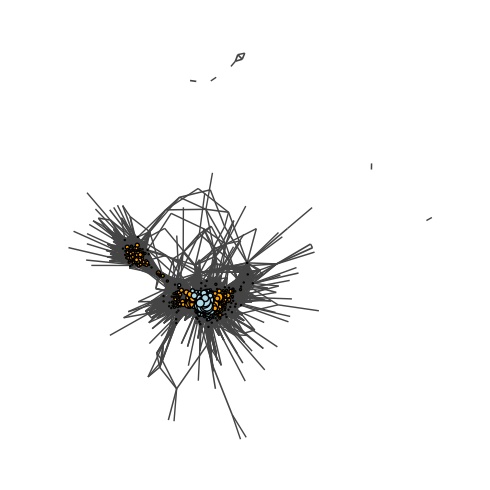

In [48]:
from igraph import plot
import matplotlib.pyplot as plt 



# 设置节点大小和颜色
node_size = [deg * 0.05 for deg in degree_centrality]
node_color = ["lightblue" if c == 0 else "orange" for c in communities.membership]

# 绘制网络图
fig, ax = plt.subplots(figsize= (5, 5))
plot(
    g,
    vertex_size=node_size,
    vertex_color=node_color,
    # vertex_label=g.vs["name"],
    vertex_label_size = 5,
    edge_width=[abs(w) * 2 for w in g.es["weight"]],
    layout=g.layout("fr"),  # 使用 Fruchterman-Reingold 布局
    bbox=(800, 800),
    margin=50,
    target= ax
)
plt.tight_layout()

# 5. <a id='toc5_'></a>[Convert](#toc0_)

In [49]:
# from deepspore.ipynb2py import ipynb2 


# ipynb2(ipynb_file= "./pipeline.ipynb", label= "#@save", output_file= "./utils/amplicon.py")